In [1]:
import os
import sys
import tarfile
from tqdm.notebook import tqdm
# Patch the path to include local libs
sys.path.insert(0, os.path.abspath('./libs'))

In [2]:
from training.PL_train import Main_Loop
import torch.optim as optim
import torch
import numpy as np
import torchio as tio
from data.data_loader import MyDataModule
import matplotlib.pyplot as plt

In [10]:
model_paths = {
    "Unet":"results/seg_examples/Unet/checkpoints/epoch=49-step=10000.ckpt",
    "custom":"results/seg_examples/custom/checkpoints/epoch=49-step=10000.ckpt",
    "deeplabv3plus":"results/seg_examples/dlv3/checkpoints/epoch=49-step=10000.ckpt"
}

In [12]:
size = (48, 64, 48)
batch_size = 1
epochs = 50
weight = torch.from_numpy(np.array([0.1, 1, 1, 1, 1])).float().cuda()

val_transformer = tio.Compose([
  tio.ToCanonical(),
  tio.Resample(4),
  tio.CropOrPad(size),
  tio.ZNormalization(masking_method=tio.ZNormalization.mean),
])

train_transformer = tio.Compose([
  tio.RandomMotion(p=0.2),
  tio.RandomBiasField(p=0.3),
  tio.ZNormalization(masking_method=tio.ZNormalization.mean),
  tio.RandomNoise(p=0.5),
  tio.RandomFlip(),
  tio.OneOf({
    tio.RandomAffine(): 0.8,
    tio.RandomElasticDeformation(): 0.2,
  }),
])

In [5]:
model_params = {}

model_params["custom"] = {
"model":"custom",
"loss":'Focal',
"type_list": ["t2"],
"scheduler":optim.lr_scheduler.ExponentialLR,
"scheduler_args":{"gamma": 0.95},
"model_args":{},
"optimizer":optim.Adam,
"optimizer_args":{"amsgrad": True},
"batch_size":batch_size,
"loss_args":{"weight": weight}
}

model_params["Unet"] = {
"model":"Unet",
"loss":'Focal',
"type_list": ["t2"],
"scheduler":optim.lr_scheduler.ExponentialLR,
"scheduler_args":{"gamma": 0.95},
"model_args":{},
"optimizer":optim.Adam,
"optimizer_args":{"amsgrad": True},
"batch_size":batch_size,
"loss_args":{"weight": weight}
}

model_params["deeplabv3plus"] = {
"model":"deeplabv3plus",
"loss":'Focal',
"type_list": ["t2"],
"scheduler":optim.lr_scheduler.ExponentialLR,
"scheduler_args":{"gamma": 0.95},
"model_args":{},
"optimizer":optim.RMSprop,
"optimizer_args":{"centered":True},
"batch_size":batch_size,
"loss_args":{"weight": weight}
}


In [13]:
models = list(model_params.keys())

In [14]:
model_dict = { model:Main_Loop(**model_params[model]) for model in models}

In [15]:
for model in model_paths.keys():
    model_dict[model] = model_dict[model].load_from_checkpoint(checkpoint_path=model_paths[model]) 

In [16]:
for model in model_dict.keys():
    model_dict[model] = model_dict[model].cuda()

In [17]:
#Need to point to point to where you want to store IXI data 

dataset = tio.datasets.ixi.IXI(root ="/home/ludauter/Documents/IXI/",transform=val_transformer ,download=True,modalities  =[ "T2"] )

In [18]:
data_loader = torch.utils.data.DataLoader(
                dataset,
                batch_size=1,
                shuffle=False,
                num_workers=3,
            )

In [19]:
for batch in data_loader:
    break

In [20]:
def get_model_results(model,model_dict,data_loader):
    try:
        results = []
        for batch in tqdm(data_loader):
            with torch.no_grad():
                pred = model_dict[model](batch["T2"]["data"].cuda()).softmax(dim=1).cpu().numpy()
                total = (pred[0,1]>.7).sum()/(48**2*64)
                results.append(total)
        return results        
    except:
        results = []
        for batch in tqdm(data_loader):
            with torch.no_grad():
                pred = model_dict[model](batch["t2"]["data"].cuda()).softmax(dim=1).cpu().numpy()
                total = (pred[0,1]>.7).sum()/(48**2*64)
                results.append(total)
        return results     

In [21]:
result_dict = {}

In [22]:
PROCESSED_DATA_PATH = os.path.abspath("./data/processed")
RAW_DATA_PATH = os.path.abspath("./data/raw")
data_module = MyDataModule(
  data_dir=RAW_DATA_PATH,
  out_dir=PROCESSED_DATA_PATH,
  train_transformer=train_transformer,
  val_transformer=val_transformer,
  size=size,
  type_list=["t2"],
  sample_list=["t2"],
  batch_size = 1
)
data_module.setup()


test_loader = data_module.test_dataloader()

/home/ludauter/tumor-segmentation/data/processed


In [23]:
# results_all = {}
# for model in model_dict.keys():
    
#     results_IXI = get_model_results(model,model_dict,data_loader)
#     results_test = get_model_results(model,model_dict,test_loader)

#     results_all[model]= (results_IXI, results_test)

In [39]:
# name = "custom"

# results_IXI = results_all[name][0]
# results_test = results_all[name][1]
# _ = plt.hist([result   for result in results_test],bins = 50,label = "Tumor")
# _ = plt.hist([result    for result in results_IXI],bins = 10,label = "Healthy")


# plt.xlabel("Tumor Fraction of Volume")
# plt.ylabel("Freuqncey")
# plt.legend(loc = "best")

# plt.savefig(name + ".png")

In [40]:
# for i,batch in  enumerate(data_loader):
#     if i ==44:
#         break
# FIRST = 0
# FOREGROUND = 1
# index = 1
# with torch.no_grad():
#     pred = model_dict["deeplabv3plus"](batch["T2"]["data"].cuda().float()).softmax(dim=1).cpu() > .7
#     targets = torch.zeros_like(pred)

# subject = tio.Subject(
#     mri=tio.ScalarImage(tensor=batch["T2"]["data"][0] ),
#     label=tio.LabelMap(tensor=targets[0]),
#     predicted=tio.ScalarImage(tensor=pred[0,index].unsqueeze(0) ),
# )
# subject.plot(figsize=(9, 8), cmap_dict={'predicted': 'RdBu_r'})

In [24]:
model_dict.keys()

dict_keys(['custom', 'Unet', 'deeplabv3plus'])

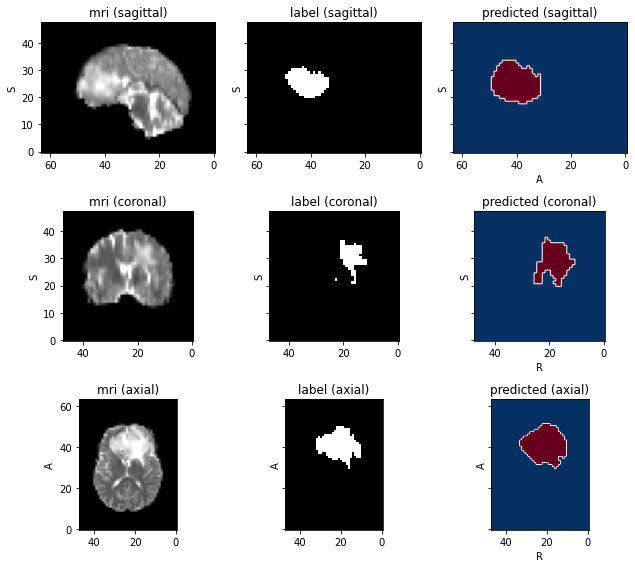

In [25]:
for i,batch in  enumerate(test_loader):
    if i ==44:
        break
FIRST = 0
FOREGROUND = 1
index = 0
with torch.no_grad():
    pred = model_dict["custom"](batch["t2"]["data"].cuda().float()).softmax(dim=1).cpu() 
    pred[0,index] = 1-(pred[0,index] - pred[0,index].min())/(pred[0,index].max()-pred[0,index].min())
    pred[0,index] = pred[0,index] > .5

    targets = batch["seg"]["data"]  > 0

subject = tio.Subject(
    mri=tio.ScalarImage(tensor=batch["t2"]["data"][0] ),
    label=tio.LabelMap(tensor=targets[0]),
    predicted=tio.ScalarImage(tensor= pred[0,index].unsqueeze(0) ),
)
subject.plot(figsize=(9, 8), cmap_dict={'predicted': 'RdBu_r'})